In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as s
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
from utility import PandasSelector

## Load data and preprocess

In [2]:
data = pd.read_csv('data.csv')
df = data.drop(['Unnamed: 32', 'id'], axis=1)

X = df.drop(labels='diagnosis',axis=1)
Y = df['diagnosis']
col = X.columns.tolist()

## Visualization
### Correlation

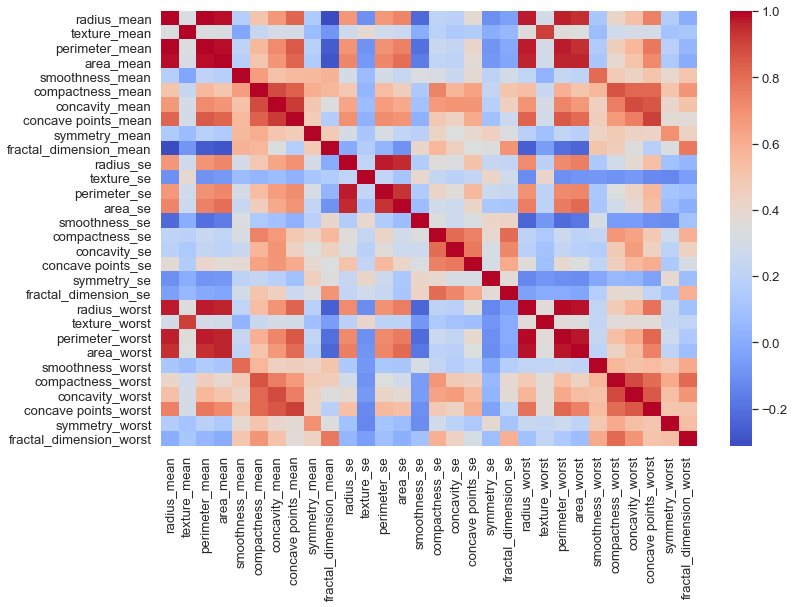

In [3]:
plt.rcParams['figure.figsize']=(12,8)
s.set(font_scale=1.2)
s.heatmap(X.corr(), cmap='coolwarm');

### Boxplots by class 

In [4]:
def boxplots_by_class(df, list_of_X, y='diagnosis'):
    plt.rcParams['figure.figsize']=(10,5)
    f, ax = plt.subplots(1,len(list_of_X))
    for i in range(len(list_of_X)):
        s.boxplot(y, y=list_of_X[i], data=df, ax=ax[i], palette='coolwarm')
    f.tight_layout()

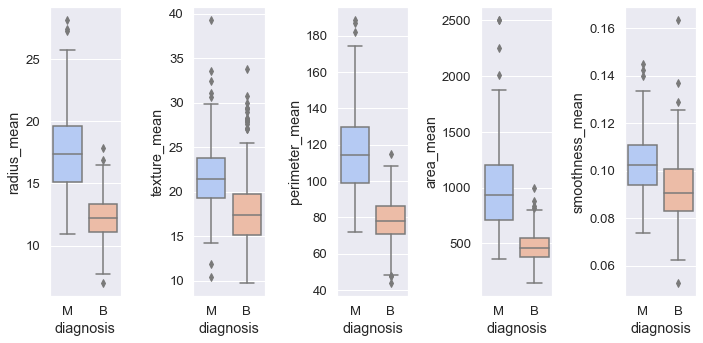

In [5]:
boxplots_by_class(df=df, list_of_X=col[:5])
# boxplots_by_class(df=df, list_of_X=col[5:10])
# boxplots_by_class(df=df, list_of_X=col[10:15])
# boxplots_by_class(df=df, list_of_X=col[15:20])
# boxplots_by_class(df=df, list_of_X=col[20:25])
# boxplots_by_class(df=df, list_of_X=col[25:])

### Histograms by class

In [6]:
def hist_by_class(df, list_of_X, y='diagnosis'):
    plt.rcParams['figure.figsize']=(10,5)

    
    for i in range(len(list_of_X)):
#         g = s.FacetGrid(df, col=y, hue=y)
        g = s.FacetGrid(df, hue=y)
        g.map(s.distplot, list_of_X[i], hist=True, rug=False).add_legend()


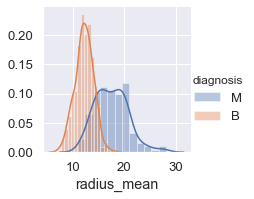

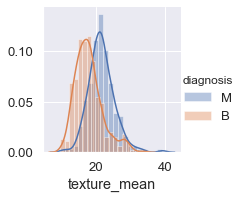

In [7]:
hist_by_class(df, list_of_X=col[:2])

## Build model and save

In [8]:
grid = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={'n_estimators': [100, 200, 500], 
                    'max_depth': [3, 8]},
        cv=3, 
        scoring='roc_auc',
        n_jobs=-1)

In [9]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram')


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

keep_features = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean']

x_proc = make_pipeline(
    PandasSelector(keep_features),
    StandardScaler())


# y_proc = make_pipeline(PandasSelector(['diagnosis']), 
#                        OneHotEncoder(handle_unknown='ignore'))

pipeline_features = ('features', FeatureUnion([
    ('xp', x_proc)
#     ('yp', y_proc)
    ]))

pipe = Pipeline([pipeline_features, ("estimator", 
                                     grid
                                    )
                ])
pipe.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('xp',
                                                 Pipeline(steps=[('pandasselector',
                                                                  PandasSelector(key=['radius_mean',
                                                                                      'texture_mean',
                                                                                      'smoothness_mean',
                                                                                      'compactness_mean'])),
                                                                 ('standardscaler',
                                                                  StandardScaler())]))])),
                ('estimator',
                 GridSearchCV(cv=3, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'max_depth': [3, 8],
                                          'n_estimators': [100, 200, 500]},
                              scoring='roc_auc'))])

In [10]:
# !conda list | grep scikit-learn

In [11]:
best_params = pipe['estimator'].best_params_
x_test_transform = pipe['features'].transform(x_test)
pred = pipe['estimator'].predict(x_test_transform)

print('Best Params :', best_params)
print('Classification Report :', classification_report(y_test, pred))

Best Params : {'max_depth': 3, 'n_estimators': 500}
Classification Report :               precision    recall  f1-score   support

           B       0.94      0.95      0.94       106
           M       0.92      0.89      0.91        65

    accuracy                           0.93       171
   macro avg       0.93      0.92      0.93       171
weighted avg       0.93      0.93      0.93       171



### Plot feature importance

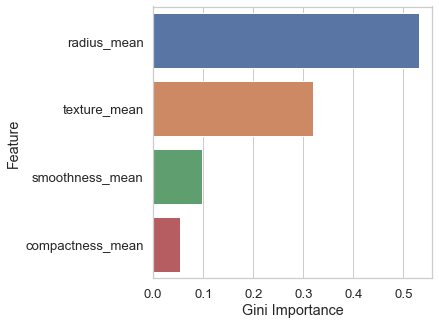

In [12]:
forest = pipe['estimator'].best_estimator_
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_imp = pd.DataFrame({'Feature': keep_features,
                        'Gini importance': importances[indices]})
plt.rcParams['figure.figsize']=(5,5)
s.set_style('whitegrid')
ax = s.barplot(x='Gini importance', y='Feature', data=feat_imp)
ax.set(xlabel='Gini Importance')
plt.show()

In [13]:
df[keep_features].head(2)

,radius_mean,texture_mean,smoothness_mean,compactness_mean
0,17.99,10.38,0.11840,0.27760
1,20.57,17.77,0.08474,0.07864


In [14]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))
# pipe = pickle.load(open('pipe.pkl','rb'))